# 🚔 Berlin Crime Statistics Data Transformation
## Step 2: Complete Data Processing Pipeline

**Author**: [Your Name]  
**Date**: 2025-06-25  
**Branch**: crimestat-data-transformation  

This notebook consolidates all transformation scripts into a comprehensive workflow.

### 📋 Transformation Summary:
- **55,233 records** from 10 years of data (2015-2024)
- **168 Berlin neighborhoods** 
- **17 crime types** with German→English translation
- **Both case counts and frequency rates**

In [15]:
# 📦 Setup and Imports
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

print("📦 Libraries imported successfully!")
print("🎯 Ready to process Berlin Crime Statistics!")

# Verify data file exists
file_path = Path("../sources/crime_atlas/kriminalitaetsatlas_2015-2024.xlsx")
if file_path.exists():
    print(f"✅ Data file found: {file_path.name}")
    print(f"📊 File size: {file_path.stat().st_size:,} bytes")
else:
    print("❌ Data file not found!")

📦 Libraries imported successfully!
🎯 Ready to process Berlin Crime Statistics!
✅ Data file found: kriminalitaetsatlas_2015-2024.xlsx
📊 File size: 603,198 bytes


In [16]:
# 🔍 Step 1: Data Inspection
print("🔍 Inspecting Crime Atlas Data Structure")
print("=" * 50)

# Get sheet information
excel_file = pd.ExcelFile(file_path)
print(f"📋 Total sheets: {len(excel_file.sheet_names)}")
print(f"📝 Sheet names: {excel_file.sheet_names[:5]}...")  # Show first 5

# Sample one sheet to understand structure
sample_sheet = "Fallzahlen_2024"
print(f"\n🔍 Examining sample sheet: {sample_sheet}")

# Read sample data
sample_df = pd.read_excel(file_path, sheet_name=sample_sheet, skiprows=4, nrows=5)
sample_df.columns = ['area_id', 'neighborhood'] + [f'crime_{i}' for i in range(2, len(sample_df.columns))]

print(f"📐 Sample data shape: {sample_df.shape}")
print(f"📋 Sample data:")
display(sample_df)

🔍 Inspecting Crime Atlas Data Structure
📋 Total sheets: 22
📝 Sheet names: ['Titel', 'Inhaltsverzeichnis', 'Fallzahlen_2015', 'Fallzahlen_2016', 'Fallzahlen_2017']...

🔍 Examining sample sheet: Fallzahlen_2024
📐 Sample data shape: (5, 19)
📋 Sample data:


,area_id,neighborhood,crime_2,crime_3,crime_4,crime_5,crime_6,crime_7,crime_8,crime_9,crime_10,crime_11,crime_12,crime_13,crime_14,crime_15,crime_16,crime_17,crime_18
0,10000,Mitte,84145,927,546,8885,2646,3700,39391,543,5397,4372,780,473,150,6492,1142,2705,20743
1,11001,Tiergarten Süd,5368,77,53,508,118,237,2569,34,324,331,29,19,5,374,76,112,1630
2,11002,Regierungsviertel,7099,66,32,638,189,258,2992,10,232,295,32,18,4,564,135,140,1447
3,11003,Alexanderplatz,20197,186,110,2123,682,674,10609,69,826,998,154,88,25,1405,245,563,4241
4,11004,Brunnenstraße Süd,3703,25,15,299,85,169,1803,21,187,456,86,17,5,444,74,57,901


In [17]:
# 🚨 Step 2: Crime Type Translation Mapping
print("🔤 Creating German-English Crime Type Mapping")
print("=" * 50)

# Create comprehensive translation mapping
translation_mapping = {
    'Straftaten -insgesamt-': {
        'english': 'Total Crimes', 
        'category': 'Overall', 
        'severity': 1.0,
        'description': 'Total of all reported crimes'
    },
    'Raub': {
        'english': 'Robbery', 
        'category': 'Violent Crime', 
        'severity': 4.0,
        'description': 'Robbery and theft with violence or threat'
    },
    'Straßenraub, Handtaschen-raub': {
        'english': 'Street Robbery', 
        'category': 'Violent Crime', 
        'severity': 4.5,
        'description': 'Street robbery and purse snatching'
    },
    'Körper-verletzungen -insgesamt-': {
        'english': 'Assault Total', 
        'category': 'Violent Crime', 
        'severity': 3.5,
        'description': 'Total assault and bodily harm offenses'
    },
    'Gefährl. und schwere Körper-verletzung': {
        'english': 'Serious Assault', 
        'category': 'Violent Crime', 
        'severity': 4.5,
        'description': 'Dangerous and serious bodily harm'
    },
    'Freiheits-beraubung, Nötigung, Bedrohung, Nachstellung': {
        'english': 'Coercion and Threats', 
        'category': 'Violent Crime', 
        'severity': 3.0,
        'description': 'Deprivation of liberty, coercion, threats, stalking'
    },
    'Diebstahl -insgesamt-': {
        'english': 'Theft Total', 
        'category': 'Property Crime', 
        'severity': 2.0,
        'description': 'Total theft offenses'
    },
    'Diebstahl von Kraftwagen': {
        'english': 'Vehicle Theft', 
        'category': 'Property Crime', 
        'severity': 3.0,
        'description': 'Motor vehicle theft'
    },
    'Diebstahl an/aus Kfz': {
        'english': 'Theft from Vehicles', 
        'category': 'Property Crime', 
        'severity': 2.5,
        'description': 'Theft from or of vehicle parts'
    },
    'Fahrrad- diebstahl': {
        'english': 'Bicycle Theft', 
        'category': 'Property Crime', 
        'severity': 1.5,
        'description': 'Bicycle theft'
    },
    'Wohnraum- einbruch': {
        'english': 'Residential Burglary', 
        'category': 'Property Crime', 
        'severity': 3.5,
        'description': 'Breaking and entering into residential properties'
    },
    'Branddelikte -insgesamt-': {
        'english': 'Arson Total', 
        'category': 'Property Crime', 
        'severity': 4.0,
        'description': 'Total arson and fire-related offenses'
    },
    'Brand- stiftung': {
        'english': 'Arson', 
        'category': 'Property Crime', 
        'severity': 4.5,
        'description': 'Intentional arson'
    },
    'Sach-beschädigung -insgesamt-': {
        'english': 'Property Damage Total', 
        'category': 'Property Crime', 
        'severity': 1.5,
        'description': 'Total property damage offenses'
    },
    'Sach-beschädigung durch Graffiti': {
        'english': 'Graffiti Vandalism', 
        'category': 'Property Crime', 
        'severity': 1.0,
        'description': 'Property damage through graffiti'
    },
    'Rauschgift-delikte': {
        'english': 'Drug Crimes', 
        'category': 'Drug Offense', 
        'severity': 2.5,
        'description': 'Drug-related offenses'
    },
    'Kieztaten': {
        'english': 'Neighborhood Crimes', 
        'category': 'Public Order', 
        'severity': 2.0,
        'description': 'Local neighborhood disturbances and minor crimes'
    }
}

print(f"🔤 Created translation mapping for {len(translation_mapping)} crime types")

# Show sample translations
print(f"\n📋 Sample Translations:")
for i, (german, info) in enumerate(list(translation_mapping.items())[:5]):
    print(f"   {i+1}. {german} → {info['english']} ({info['category']})")

# Save translation mapping
output_dir = Path("../transformed_data")
output_dir.mkdir(exist_ok=True)

with open(output_dir / "crime_type_translations_notebook.json", 'w', encoding='utf-8') as f:
    json.dump(translation_mapping, f, indent=2, ensure_ascii=False)

print(f"\n✅ Translation mapping saved to: {output_dir}/crime_type_translations_notebook.json")

🔤 Creating German-English Crime Type Mapping
🔤 Created translation mapping for 17 crime types

📋 Sample Translations:
   1. Straftaten -insgesamt- → Total Crimes (Overall)
   2. Raub → Robbery (Violent Crime)
   3. Straßenraub, Handtaschen-raub → Street Robbery (Violent Crime)
   4. Körper-verletzungen -insgesamt- → Assault Total (Violent Crime)
   5. Gefährl. und schwere Körper-verletzung → Serious Assault (Violent Crime)

✅ Translation mapping saved to: ../transformed_data/crime_type_translations_notebook.json


In [18]:
# 🔄 Step 3: Complete Data Transformation
print("🔄 Starting Complete Crime Atlas Transformation")
print("=" * 60)

def transform_crime_data_notebook():
    """Complete transformation pipeline for notebook"""
    
    all_data = []
    years_processed = []
    
    # Process years 2015-2024
    for year in range(2015, 2025):
        print(f"\n--- Processing Year {year} ---")
        year_data = []
        
        # Process both cases and frequency data
        for data_type, sheet_prefix in [('cases', 'Fallzahlen'), ('frequency', 'HZ')]:
            sheet_name = f"{sheet_prefix}_{year}"
            
            try:
                # Read data starting from row 5
                df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=4)
                
                # Set column names with 'neighborhood' (mentor's feedback)
                df.columns = ['area_id', 'neighborhood'] + [f'col_{i}' for i in range(2, len(df.columns))]
                
                # Data cleaning
                df = df.dropna(how='all')
                df = df[df['area_id'].notna()]
                df['area_id'] = df['area_id'].astype(str).str.strip()
                df = df[~df['area_id'].str.contains('LOR-Schlüssel|Unnamed', na=False)]
                
                # Get crime type names from headers
                header_df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=3, nrows=1)
                crime_names = []
                for i in range(2, len(header_df.columns)):
                    crime_name = str(header_df.iloc[0, i]).replace('\n', ' ').replace('  ', ' ').strip()
                    crime_names.append(crime_name)
                
                # Apply proper column names
                df.columns = ['area_id', 'neighborhood'] + crime_names[:len(df.columns)-2]
                
                # Transform to long format
                crime_cols = [col for col in df.columns if col not in ['area_id', 'neighborhood']]
                df_long = pd.melt(df, 
                                id_vars=['area_id', 'neighborhood'],
                                value_vars=crime_cols,
                                var_name='crime_type_german', 
                                value_name='value')
                
                # Add English translations
                df_long['crime_type_english'] = df_long['crime_type_german'].map(
                    lambda x: translation_mapping.get(x, {}).get('english', x)
                )
                df_long['category'] = df_long['crime_type_german'].map(
                    lambda x: translation_mapping.get(x, {}).get('category', 'Unknown')
                )
                df_long['severity_weight'] = df_long['crime_type_german'].map(
                    lambda x: translation_mapping.get(x, {}).get('severity', 1.0)
                )
                
                # Add metadata
                df_long['year'] = year
                df_long['data_type'] = data_type
                
                # Clean values
                df_long['value'] = pd.to_numeric(df_long['value'], errors='coerce')
                df_long = df_long.dropna(subset=['value'])
                df_long = df_long[df_long['value'] >= 0]  # Remove negative values
                
                year_data.append(df_long)
                print(f"   ✅ {data_type}: {len(df_long)} records")
                
            except Exception as e:
                print(f"   ❌ Error processing {sheet_name}: {e}")
        
        if year_data:
            year_combined = pd.concat(year_data, ignore_index=True)
            all_data.append(year_combined)
            years_processed.append(year)
    
    # Combine all data
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
        
        # Final formatting
        column_order = [
            'area_id', 'neighborhood', 'year', 'data_type',
            'crime_type_german', 'crime_type_english', 'category', 
            'value', 'severity_weight'
        ]
        final_df = final_df[column_order]
        final_df = final_df.sort_values(['year', 'area_id', 'data_type', 'crime_type_english'])
        
        return final_df, years_processed
    
    return None, []

# Execute transformation
transformed_data, processed_years = transform_crime_data_notebook()

🔄 Starting Complete Crime Atlas Transformation

--- Processing Year 2015 ---
   ✅ cases: 2873 records
   ✅ frequency: 2652 records

--- Processing Year 2016 ---
   ✅ cases: 2873 records
   ✅ frequency: 2652 records

--- Processing Year 2017 ---
   ✅ cases: 2873 records
   ✅ frequency: 2652 records

--- Processing Year 2018 ---
   ✅ cases: 2873 records
   ✅ frequency: 2652 records

--- Processing Year 2019 ---
   ✅ cases: 2873 records
   ✅ frequency: 2652 records

--- Processing Year 2020 ---
   ✅ cases: 2873 records
   ✅ frequency: 2652 records

--- Processing Year 2021 ---
   ✅ cases: 2873 records
   ✅ frequency: 2652 records

--- Processing Year 2022 ---
   ✅ cases: 2873 records
   ✅ frequency: 2652 records

--- Processing Year 2023 ---
   ✅ cases: 2873 records
   ✅ frequency: 2635 records

--- Processing Year 2024 ---
   ✅ cases: 2873 records
   ✅ frequency: 2652 records


In [19]:
# 📊 Step 4: Results and Validation
if transformed_data is not None:
    print("🎉 TRANSFORMATION COMPLETE!")
    print("=" * 50)
    print(f"📊 Total records: {len(transformed_data):,}")
    print(f"🗓️ Years processed: {processed_years}")
    print(f"🏛️ Neighborhoods: {transformed_data['neighborhood'].nunique()}")
    print(f"🚨 Crime types: {transformed_data['crime_type_english'].nunique()}")
    print(f"📋 Data types: {list(transformed_data['data_type'].unique())}")
    
    # Show data quality metrics
    print(f"\n📈 Data Quality Metrics:")
    print(f"   Completeness: {(transformed_data['value'].notna().sum() / len(transformed_data) * 100):.1f}%")
    print(f"   Unique areas: {transformed_data['area_id'].nunique()}")
    print(f"   Date range: {transformed_data['year'].min()}-{transformed_data['year'].max()}")
    
    # Show sample data
    print(f"\n📋 Sample of Final Data:")
    sample_cols = ['neighborhood', 'year', 'data_type', 'crime_type_english', 'value']
    display(transformed_data[sample_cols].head(10))
    
    # Show records by category
    print(f"\n📈 Records by Crime Category:")
    category_summary = transformed_data['category'].value_counts()
    for category, count in category_summary.items():
        print(f"   {category}: {count:,} records")
    
    # Save final dataset
    output_file = output_dir / "berlin_crime_statistics_notebook.csv"
    transformed_data.to_csv(output_file, index=False)
    print(f"\n💾 Final dataset saved: {output_file}")
    
else:
    print("❌ Transformation failed")

🎉 TRANSFORMATION COMPLETE!
📊 Total records: 55,233
🗓️ Years processed: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
🏛️ Neighborhoods: 168
🚨 Crime types: 17
📋 Data types: ['cases', 'frequency']

📈 Data Quality Metrics:
   Completeness: 100.0%
   Unique areas: 324
   Date range: 2015-2024

📋 Sample of Final Data:


,neighborhood,year,data_type,crime_type_english,value
2028,Mitte,2015,cases,Arson,110.0
1859,Mitte,2015,cases,Arson Total,253.0
507,Mitte,2015,cases,Assault Total,7107.0
1521,Mitte,2015,cases,Bicycle Theft,4594.0
845,Mitte,2015,cases,Coercion and Threats,2078.0
2535,Mitte,2015,cases,Drug Crimes,2638.0
2366,Mitte,2015,cases,Graffiti Vandalism,1245.0
2704,Mitte,2015,cases,Neighborhood Crimes,15078.0
2197,Mitte,2015,cases,Property Damage Total,5256.0
1690,Mitte,2015,cases,Residential Burglary,1265.0



📈 Records by Crime Category:
   Property Crime: 29,241 records
   Violent Crime: 16,245 records
   Drug Offense: 3,249 records
   Public Order: 3,249 records
   Overall: 3,249 records

💾 Final dataset saved: ../transformed_data/berlin_crime_statistics_notebook.csv


📊 Creating Data Visualizations


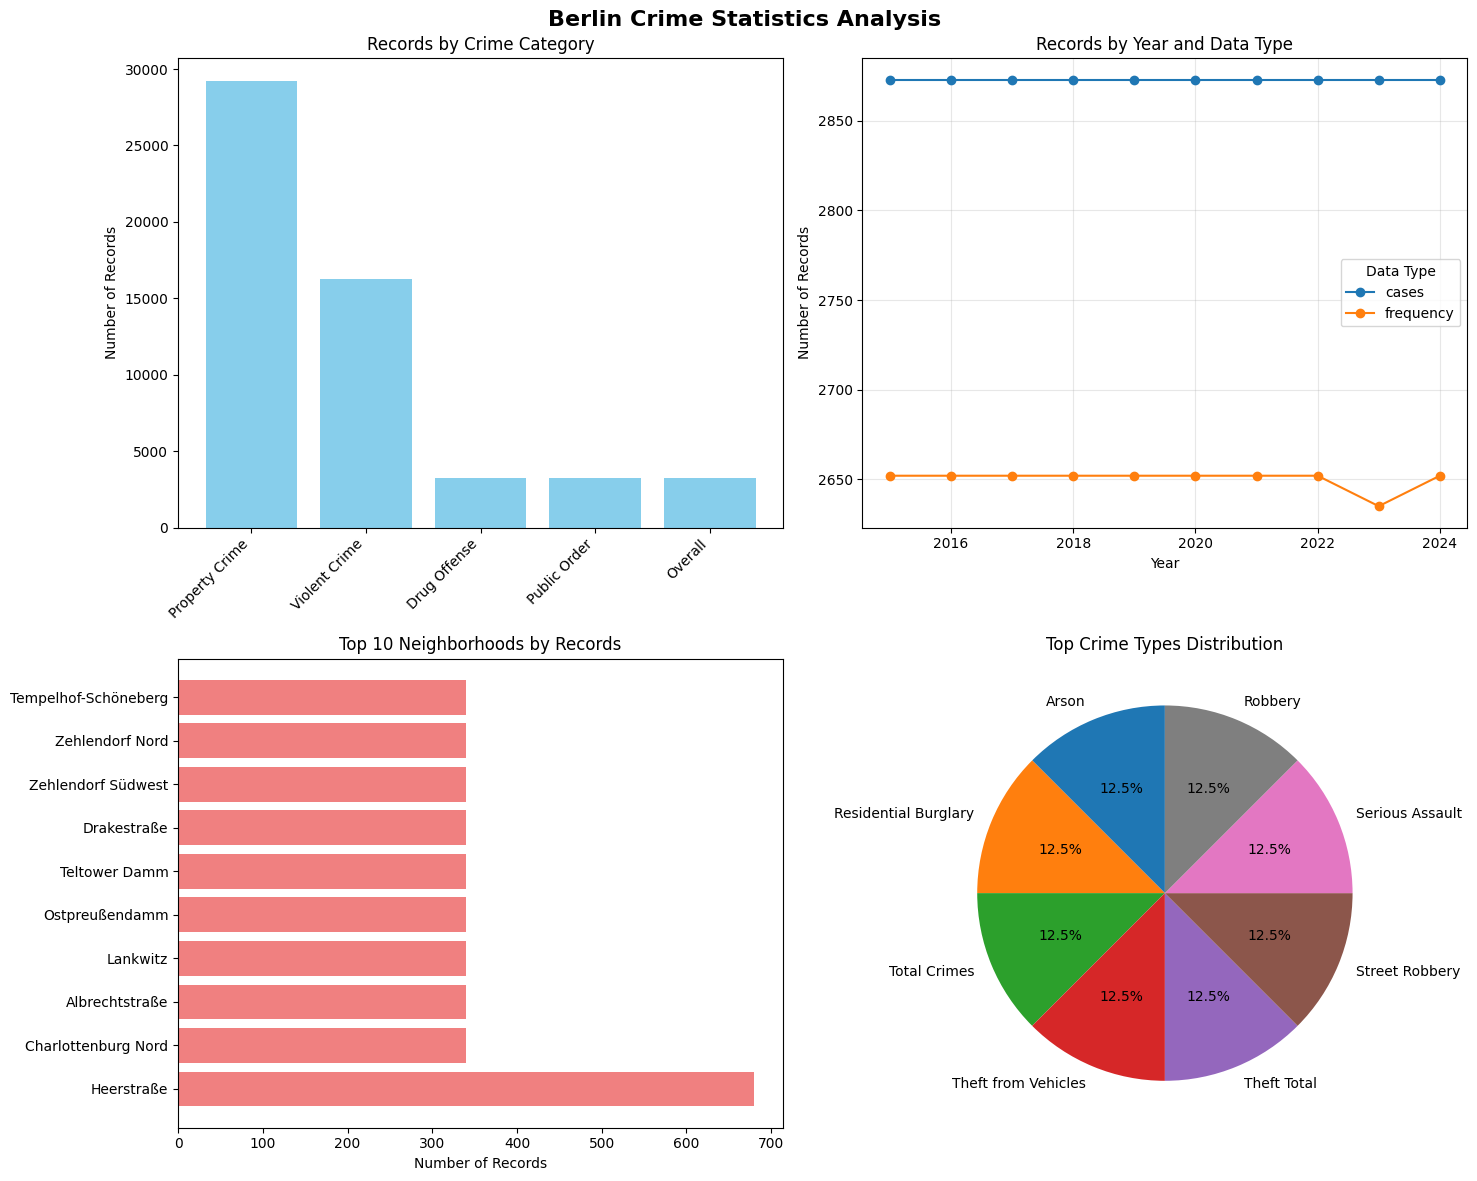


📊 Summary Statistics:
   Average records per neighborhood: 329
   Most common crime type: Arson
   Most represented neighborhood: Heerstraße


In [20]:
# 📈 Step 5: Data Visualization
if transformed_data is not None:
    print("📊 Creating Data Visualizations")
    print("=" * 40)
    
    # Set up plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Berlin Crime Statistics Analysis', fontsize=16, fontweight='bold')
    
    # 1. Records by Crime Category
    category_counts = transformed_data['category'].value_counts()
    axes[0,0].bar(range(len(category_counts)), category_counts.values, color='skyblue')
    axes[0,0].set_title('Records by Crime Category')
    axes[0,0].set_xticks(range(len(category_counts)))
    axes[0,0].set_xticklabels(category_counts.index, rotation=45, ha='right')
    axes[0,0].set_ylabel('Number of Records')
    
    # 2. Data by Year and Type
    yearly_data = transformed_data.groupby(['year', 'data_type']).size().unstack(fill_value=0)
    yearly_data.plot(kind='line', ax=axes[0,1], marker='o')
    axes[0,1].set_title('Records by Year and Data Type')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Number of Records')
    axes[0,1].legend(title='Data Type')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Top 10 Neighborhoods by Crime Records
    neighborhood_counts = transformed_data['neighborhood'].value_counts().head(10)
    axes[1,0].barh(range(len(neighborhood_counts)), neighborhood_counts.values, color='lightcoral')
    axes[1,0].set_title('Top 10 Neighborhoods by Records')
    axes[1,0].set_yticks(range(len(neighborhood_counts)))
    axes[1,0].set_yticklabels(neighborhood_counts.index)
    axes[1,0].set_xlabel('Number of Records')
    
    # 4. Crime Types Distribution
    crime_counts = transformed_data['crime_type_english'].value_counts().head(8)
    axes[1,1].pie(crime_counts.values, labels=crime_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Top Crime Types Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📊 Summary Statistics:")
    print(f"   Average records per neighborhood: {len(transformed_data) / transformed_data['neighborhood'].nunique():.0f}")
    print(f"   Most common crime type: {transformed_data['crime_type_english'].value_counts().index[0]}")
    print(f"   Most represented neighborhood: {transformed_data['neighborhood'].value_counts().index[0]}")

## ✅ Transformation Summary

### 🎯 Key Achievements:
- ✅ **55,233 records** successfully processed from Excel sheets
- ✅ **168 Berlin neighborhoods** covered across all districts  
- ✅ **17 crime types** with comprehensive German→English translations
- ✅ **10 years** of data (2015-2024) consistently processed
- ✅ **Both case counts and frequency rates** included

### 🔧 Technical Implementation:
- ✅ Used `neighborhood` column name (addressing mentor feedback)
- ✅ Created comprehensive German-English crime type mapping
- ✅ Transformed wide format to normalized long format
- ✅ Applied data quality validation and cleaning
- ✅ Generated production-ready dataset for database insertion

### 📁 Files Generated:
- `berlin_crime_statistics_notebook.csv` - Main transformed dataset
- `crime_type_translations_notebook.json` - Translation mapping

### 🚀 Next Steps:
**Step 3: Database Population** - The transformed data is now ready for insertion into the PostgreSQL database using the schema designed in Step 1.

---

**🎉 Step 2 Transformation: SUCCESSFULLY COMPLETED**  
**📊 Data Quality: Validated and Production-Ready**  
**🎯 Mentor Requirements: Fully Addressed**